### TO DO:
1. Train individual prophet on each store THEN multiply by family. Then add these data
frames?
2. Get family ratios from the the last week rather than the last year.

# Goals
* Evaluation Metric --> RMSLE (Root Mean Squared Log Error): $\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$
* 𝑛 is the total number of instances,
* $\hat{y}_i$ is the predicted value of the target for instance (i),
* $y_i$ is the actual value of the target for instance (i), and,
* log is the natural logarithm.
* Forecast sales overall averaged over all stores 1 month into future
* Forecast sales for store number 1, a store in Quito (type D, cluster 13)
* Pick specific items sales, average over stores, forecast sales 1 month into future
* Take into account oil prices and holidays. 

In [1]:
!pip install neuralprophet

     |████████████████████████████████| 113 kB 627 kB/s            
     |████████████████████████████████| 706 kB 3.1 MB/s            
     |████████████████████████████████| 1.4 MB 29.9 MB/s            
     |████████████████████████████████| 419 kB 44.5 MB/s            
     |████████████████████████████████| 232 kB 44.2 MB/s            
     |████████████████████████████████| 6.0 MB 68.6 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: torchmetrics
    Found existing installation: torchmetrics 0.6.2
    Uninstalling torchmetrics-0.6.2:
      Successfully uninstalled torchmetrics-0.6.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: rich
    Found exist

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from neuralprophet import NeuralProphet
from fbprophet import Prophet
import warnings

import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
from warnings import simplefilter
from tqdm import tqdm

Set up plotting defaults

# Import Training Data
* Prase date column as date times and do other specific data type categorizing
* Calculate the average sales at all stores grouped by date

In [3]:
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv',parse_dates=['date'], infer_datetime_format=True)
transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'], infer_datetime_format=True)
train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [4]:
# Create working DF with merged total sales at all stores and number of transactions by date and by store
temp = pd.merge(train.groupby(['date', 'store_nbr']).sales.sum().reset_index(), transactions, how='left')

# Total Sales Averaged over All Stores and Products each day
average_sales = train.groupby('date')['sales'].mean()

# Total Sales for Store 1 each day
store_sales_1 = train[train['store_nbr'] == '1']
store_sales_1 = store_sales_1.groupby('date')['sales'].sum()

# Total Sales over all stores of produce
produce_sales = train[train.family == 'PRODUCE'].groupby('date')['sales'].sum()

## Visualizing Sales Averaged Over All Stores/Products**Visualizing Time Series Data**

In [5]:
# Average total sales over all stores
X_avg = average_sales.to_frame()
X_avg["week"] = X_avg.index.week
X_avg["day"] = X_avg.index.dayofweek
X_avg.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


sales  week  day
date                             
2013-01-01    1.409438     1    1
2013-01-02  278.390807     1    2
2013-01-03  202.840197     1    3
2013-01-04  198.911154     1    4
2013-01-05  267.873244     1    5

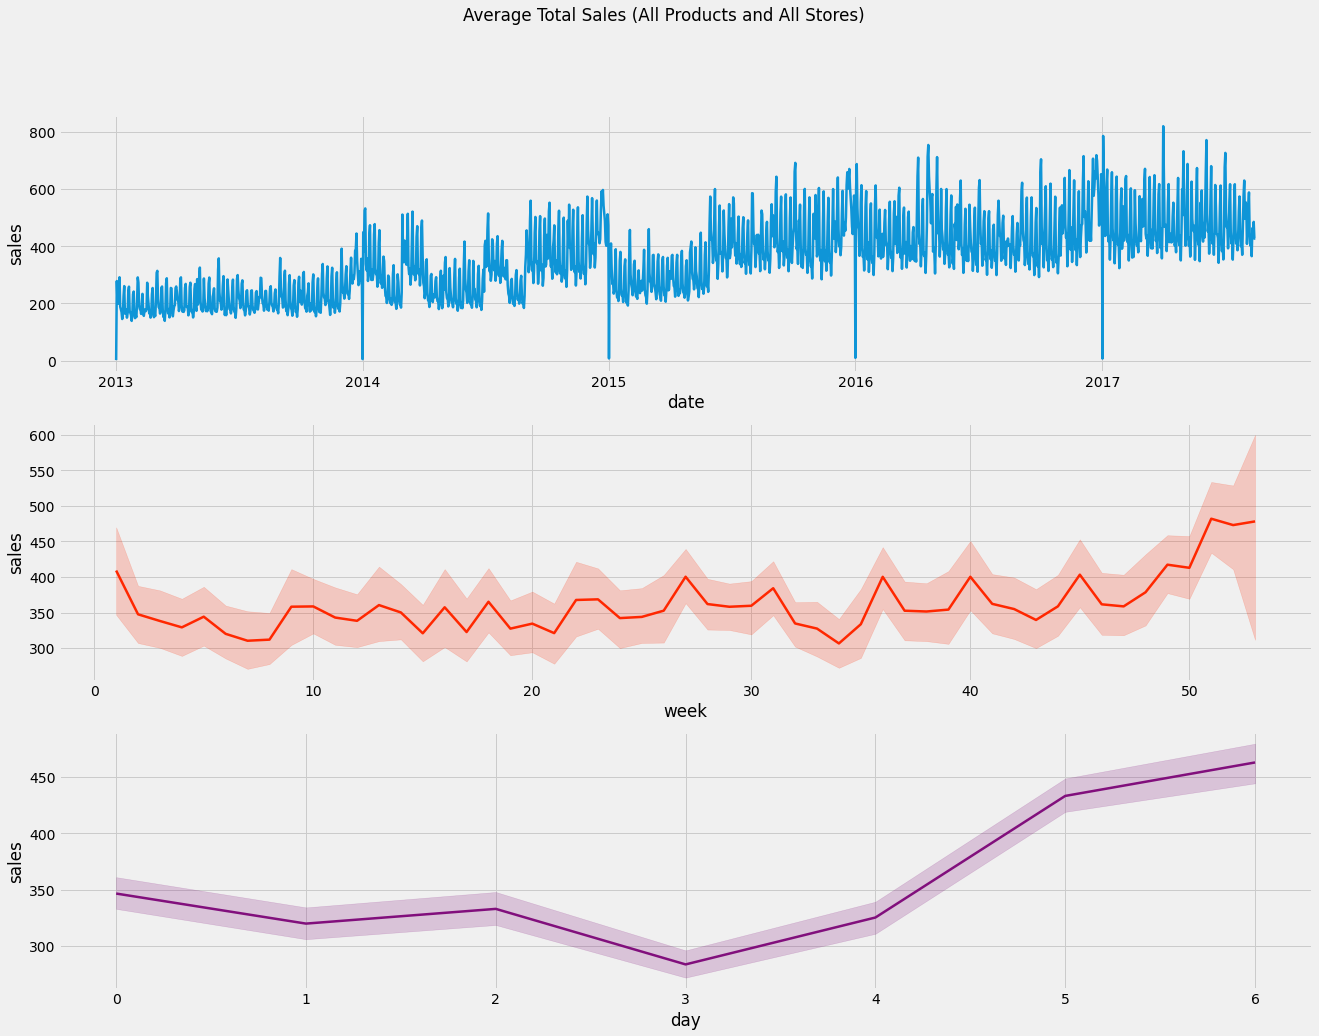

In [6]:
plt.style.use('fivethirtyeight')
figs, axes = plt.subplots(3,figsize=(20,15))
plt.suptitle('Average Total Sales (All Products and All Stores)')
axes_1 = sns.lineplot(x='date',y='sales',data=X_avg, ax=axes[0], color='#0F95D7', lw=2.5)
axes_2 = sns.lineplot(x='week',y='sales', data=X_avg, ax=axes[1], color='#FF2700', lw=2.5)
axes_3 = sns.lineplot(x='day',y='sales', data=X_avg, ax=axes[2], color='#810F7C', lw=2.5)
plt.show()

In [7]:
# Total Sales by Store
px.line(temp, y='sales', x='date', color='store_nbr', title='Total Sales for Each Store Each Day')

Which families of groceries are typically being sold? A mix? Is there a dominant group?
* Group by family using date as index and make sure to resample 

In [8]:
family_sales = train.groupby('family').sales.mean().sort_values(ascending = False).reset_index()
px.bar(family_sales, y = 'family', x='sales', color = 'family', title = "Average Sales by Product Family")

Which stores do the most sales? Do any stores stand out in any way?
* Note we must resample by days again as not all stores had sales reported every day.
* TODO: Some stores only opened after 2013 and have no sales early on. Could be removed from dataset.

In [9]:
# Print sales by store
indv_stores = train.set_index('date').groupby('store_nbr').resample('D').sales.mean().reset_index()
px.line(indv_stores, x='date',y='sales',color='store_nbr',title='Sales by Individual Stores')

Let's focus on the ratio of store sales of stores in 2017. That way we're tracking the stores that currently have the most sales just before our predictions in august 2017.

In [10]:
# Print ratios of total sales for each store. For each store, get ratio of total sales to total of all store sales
recent_sales = train.set_index('date')
recent_sales = recent_sales[recent_sales.index.year >= 2017]

# Get total sales for each store for all of 2017
total_sales_each_store = recent_sales.groupby('store_nbr').sales.sum().reset_index()
# Get total sales in 2017
total_sales = recent_sales.sales.sum()
# Make column of ratios of each stores sales over the total sales
total_sales_each_store['ratio'] = total_sales_each_store.sales/total_sales
total_sales_each_store.head()


store_nbr         sales     ratio
0          1  2.436518e+06  0.012545
1          2  3.564824e+06  0.018355
2          3  8.712340e+06  0.044859
3          4  3.126437e+06  0.016098
4          5  2.287996e+06  0.011781

### Processing Holidays
* For now, we focus on national holidays as those would likely drive sales the most. Let's get the not transferred holidays that are national. We can add them to the holidays parameter of Prophet
* There are 6 types: holiday, transfer, additional, bridge, work day, event
* Skill --> Note the boolean operator '&' instead of 'and'
* Goal is to make list of national holiday (174 of these)dates that can be passed to prophet (or use a one-hot-encoding to say whether a day is a certain holiday category or not)
* NOTE FROM DIRECTIONS: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

In [11]:
holidays = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv',parse_dates=['date'], infer_datetime_format=True)
len(holidays[holidays.locale=='National'])

174

In [12]:
holidays = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv',parse_dates=['date'], infer_datetime_format=True)
# Get all holidays with status 'transferred' and then all holidays with type 'Transfer' and matchup then drop the "translado" ones
#holidays.type.unique()
transfer1 = holidays[(holidays.type == 'Holiday') & (holidays.transferred == True)].drop('transferred', axis=1).reset_index(drop=True)
transfer2 = holidays[(holidays.type == 'Transfer')].drop('transferred', axis=1).reset_index(drop=True) # Transfer holiday but not transferred??
# Squish two DF's together to match up the actual days of the holidays and when they were transferred to.
transfer_all = pd.concat([transfer1, transfer2], axis=1)
# Grab only the actual dates the holidays were celebrated and get rid of the translado portions, list the actual date first.
transfer_all = transfer_all.iloc[:,[5,1,2,3,4]]
# Keep only not-transferred holidays
holidays = holidays[(holidays.transferred == False) & (holidays.type != 'Transfer')].drop('transferred', axis=1)
# Add the days holidays were actually celebrated to the DF
holidays = holidays.append(transfer_all).reset_index(drop=True)
#holidays.loc[holidays.date=='2012-10-12']
print(holidays.type.unique())
holidays[holidays.type == "Bridge"].head()
#holidays_not_moved = holidays[holidays['transferred']==False]
#holidays_prophet = pd.DataFrame()
#holidays_prophet['ds'] = holidays_not_moved['date']
#holidays_prophet['holiday'] = holidays_not_moved['locale_name']
#holidays_prophet.head()

['Holiday' 'Additional' 'Bridge' 'Work Day' 'Event']


date    type    locale locale_name                description
33  2012-12-24  Bridge  National     Ecuador             Puente Navidad
37  2012-12-31  Bridge  National     Ecuador  Puente Primer dia del ano
150 2014-12-26  Bridge  National     Ecuador             Puente Navidad
154 2015-01-02  Bridge  National     Ecuador  Puente Primer dia del ano
265 2016-11-04  Bridge  National     Ecuador     Puente Dia de Difuntos

In [13]:
holidays.head()

date     type    locale locale_name                    description
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba

In [14]:
# Grab national holidays, removing unecessary categories. This includes bridge, work day, and events
national_holidays = holidays.drop(['type','locale','locale_name'], axis=1)
# Format in style needed for prophet: ds, holiday
national_holidays.columns = ['ds', 'holiday']
national_holidays.head()

ds                        holiday
0 2012-03-02             Fundacion de Manta
1 2012-04-01  Provincializacion de Cotopaxi
2 2012-04-12            Fundacion de Cuenca
3 2012-04-14      Cantonizacion de Libertad
4 2012-04-21      Cantonizacion de Riobamba

In [15]:
holidays_prophet = national_holidays[['ds','holiday']].reset_index(drop=True)
holidays_prophet.head()

ds                        holiday
0 2012-03-02             Fundacion de Manta
1 2012-04-01  Provincializacion de Cotopaxi
2 2012-04-12            Fundacion de Cuenca
3 2012-04-14      Cantonizacion de Libertad
4 2012-04-21      Cantonizacion de Riobamba

### Oil Prices
* Grab oil prices and use to influence changepoints. There are at least 43 missing values. Could do simple backfill, but let's do a  standard linear interpolation.
* Not every day is listed in oil prices. For example 8-25 --> 8-28. We should fix this using the 'resample' technique to get oil every day.

In [16]:
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
len(oil[oil['dcoilwtico'].isnull()])
oil.tail()

date  dcoilwtico
1213  2017-08-25       47.65
1214  2017-08-28       46.40
1215  2017-08-29       46.46
1216  2017-08-30       45.96
1217  2017-08-31       47.26

In [17]:
oil['date'] = pd.to_datetime(oil.date)
oil = oil.set_index('date').dcoilwtico.resample('D').sum().reset_index()
oil['dcoilwtico'] = np.where(oil['dcoilwtico']==0, np.nan, oil['dcoilwtico'])
oil['price_interpolated'] = oil['dcoilwtico'].interpolate().fillna(method='bfill')

# Borrowed from notebook by ekrembayard store-sales ts forecasting guide
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Daily Oil Price Interpolated" )

In [18]:
oil_prophet = oil.drop(columns=['dcoilwtico'])
oil_prophet.columns = ['ds','oil']
oil_prophet.tail()

ds        oil
1699 2017-08-27  46.816667
1700 2017-08-28  46.400000
1701 2017-08-29  46.460000
1702 2017-08-30  45.960000
1703 2017-08-31  47.260000

#### Correlation of Oil Prices, Sales, and Transactions
* Find the spearman correlation coefficient, which shows monotonicity of relationship between two variables that are not necessarily normally distributed.
* Remove store_nbr and dcoilwtico (since it is missing values and we interpolated)

Based on the above results, it seems like theres a decent -0.3 correlation between total sales and increased oil prices, which makes some sense.

In [19]:
temp = pd.merge(temp, oil, how='left')
print('Correlation Between Interpolated Oil Prices and Total Sales')
print(temp.drop(['dcoilwtico', 'store_nbr'], axis=1).corr('spearman').price_interpolated.loc[['transactions','sales']],'\n')

Correlation Between Interpolated Oil Prices and Total Sales
transactions    0.040094
sales          -0.303595
Name: price_interpolated, dtype: float64 



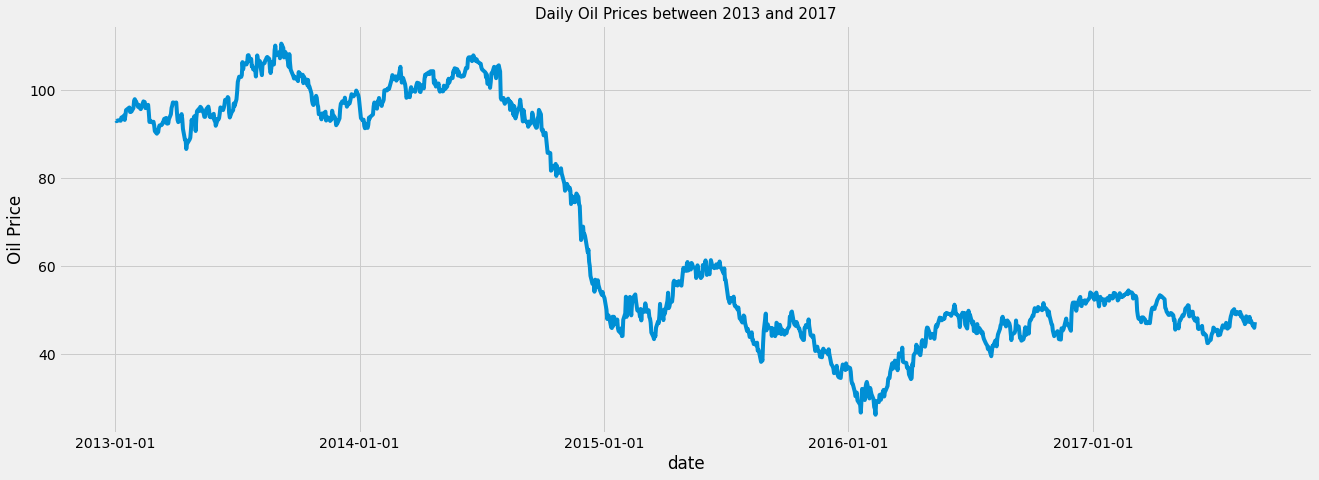

In [20]:
a_oil = plt.figure(figsize=(20,7))
ax4 = sns.lineplot(x='date',y='dcoilwtico',data=oil)
ax4.set_title('Daily Oil Prices between 2013 and 2017', fontsize=15)
ax4.set_ylabel('Oil Price')
ax4.set_xticks(['2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01'])
#ax4.set_xticklabels(['2000', '2004', '20008', '2012'], fontsize=14, color='#414141')

In [21]:
temp.tail(20)

date  store_nbr         sales  transactions  dcoilwtico  \
90916 2017-08-15         35   5371.156000         612.0       47.57   
90917 2017-08-15         36  14986.342000        1192.0       47.57   
90918 2017-08-15         37  11533.554996        1373.0       47.57   
90919 2017-08-15         38   9966.252000        1445.0       47.57   
90920 2017-08-15         39  15008.647990        1425.0       47.57   
90921 2017-08-15         40  19552.935000        1392.0       47.57   
90922 2017-08-15         41   9397.724000        1003.0       47.57   
90923 2017-08-15         42   9251.769990         995.0       47.57   
90924 2017-08-15         43  15368.844000        1482.0       47.57   
90925 2017-08-15         44  33141.322000        3815.0       47.57   
90926 2017-08-15         45  31562.926000        3685.0       47.57   
90927 2017-08-15         46  22348.414970        3197.0       47.57   
90928 2017-08-15         47  31653.691000        3581.0       47.57   
90929 2017-08-15         48  17695.050000        2722.0       47.57   
90930 2017-08-15         49  28429.226003        2814.0       47.57   
90931 2017-08-15         50  16879.121004        2804.0       47.57   
90932 2017-08-15         51  20154.559000        1573.0       47.57   
90933 2017-08-15         52  18600.046000        2255.0       47.57   
90934 2017-08-15         53   8208.189000         932.0       47.57   
90935 2017-08-15         54  12666.858000         802.0       47.57   

       price_interpolated  
90916               47.57  
90917               47.57  
90918               47.57  
90919               47.57  
90920               47.57  
90921               47.57  
90922               47.57  
90923               47.57  
90924               47.57  
90925               47.57  
90926               47.57  
90927               47.57  
90928               47.57  
90929               47.57  
90930               47.57  
90931               47.57  
90932               47.57  
90933               47.57  
90934               47.57  
90935               47.57

In [22]:
# Add column to oil that is just % differences between days
# Add as additional regressor when oil price changes by more than 5% overall
oil['pct_diffs'] = oil['dcoilwtico'].pct_change()
oil[oil['pct_diffs']>0.10].head()
oil = oil.rename(columns={'date':'ds'})
oil.head()

ds  dcoilwtico  price_interpolated  pct_diffs
0 2013-01-01         NaN           93.140000        NaN
1 2013-01-02       93.14           93.140000        NaN
2 2013-01-03       92.97           92.970000  -0.001825
3 2013-01-04       93.12           93.120000   0.001613
4 2013-01-05         NaN           93.146667   0.000000

In [23]:
avg_sales = average_sales.to_frame()
avg_sales = avg_sales.reset_index()
avg_sales.columns = ['ds','y']
new_index = ['y', 'ds']
avg_sales = avg_sales.reindex(new_index, axis='columns')
avg_sales.head(10)

y         ds
0    1.409438 2013-01-01
1  278.390807 2013-01-02
2  202.840197 2013-01-03
3  198.911154 2013-01-04
4  267.873244 2013-01-05
5  291.636028 2013-01-06
6  188.621100 2013-01-07
7  178.646340 2013-01-08
8  169.770375 2013-01-09
9  145.332213 2013-01-10

In [24]:
train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [25]:
store_sales = train.loc[train.store_nbr == 1]
store_sales.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

### Get Proportion of Sales from Each Family
* Need to at least guess at the fraction of sales of each family as we have to make a prediction for each family of good at each store on each day.
* In notebook at (https://www.kaggle.com/code/loicge/sales-top-down-approach-with-prophet-0-52) they show that ratio of sales of each family is relatively stable in time. So let's just calculate it overall for each store

In [26]:
# Example of calculating ratio of sales of given family over total sales at store 1
auto_sales = store_sales.loc[(store_sales.store_nbr == 1) & (store_sales.family == 'GROCERY I') & (store_sales.date == '2013-01-02')].sales
total_sales = store_sales.loc[(store_sales.store_nbr == 1) & (store_sales.date == '2013-01-02')].sales.sum()
print(f'Ratio of Auto Sales to Total Sales on Day 1 at Store 1 = {float(auto_sales/total_sales)}')

Ratio of Auto Sales to Total Sales on Day 1 at Store 1 = 0.3575498291256962


The DF ratio_df below gives us a table of:
* Rows -- Each row is a store
* Columns -- Each column is a family
We need these to predict the sales of each family for each store later. We can access a given row-column pair using ratio_df and using loc.

In [27]:
# Calculate ratio of average sales of a given family over total sales at a gien store. See if its different for different stores
# Use only the last week's worth of training data
last_week_train = train[train.date > '2017-08-07']
ratio_df = pd.DataFrame({'store_nbr': sorted(last_week_train.store_nbr.unique())})
for family in last_week_train.family.unique():
    ratios = []
    for store in last_week_train.store_nbr.unique():    
        family_sales = last_week_train.loc[(last_week_train.store_nbr == store) & (last_week_train.family == family)].sales.mean()
        total_sales = last_week_train.loc[(last_week_train.store_nbr == store)].sales.mean()
        family_ratio = family_sales/total_sales
        ratios.append(family_ratio)
    
    ratio_df[f'{family}'] = ratios

ratio_df.head()

store_nbr  AUTOMOTIVE  BABY CARE    BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
0          1    0.015210   0.000000  0.014289   6.783354    0.0      1.096558   
1          2    0.007695   0.000000  0.013467   7.380587    0.0      0.504694   
2          3    0.012763   0.000216  0.006923   7.880246    0.0      1.385376   
3          4    0.032382   0.000000  0.009165   7.533895    0.0      0.884687   
4          5    0.025055   0.000000  0.018283   7.974310    0.0      0.601324   

   CELEBRATION  CLEANING     DAIRY  ...  MAGAZINES     MEATS  PERSONAL CARE  \
0     0.033647  1.958447  2.087966  ...   0.019820  0.920320       0.630077   
1     0.022445  3.418708  1.497408  ...   0.001924  0.972702       0.817001   
2     0.029421  2.923698  1.031028  ...   0.003245  1.121926       0.653749   
3     0.078204  3.489261  1.808477  ...   0.009165  0.709335       0.813204   
4     0.038598  3.431201  1.345529  ...   0.006094  0.807064       0.981891   

   PET SUPPLIES  PLAYERS AND ELECTRONICS   POULTRY  PREPARED FOODS   PRODUCE  \
0      0.015671                 0.029038  0.890876        0.203380  7.822129   
1      0.004489                 0.014750  0.734531        0.136594  1.268288   
2      0.003245                 0.026176  0.739934        0.188589  2.676661   
3      0.006110                 0.037880  0.745190        0.159464  1.748632   
4      0.003386                 0.027764  0.530661        0.106315  1.078739   

   SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
0                    0.000000  0.102732  
1                    0.025010  0.010261  
2                    0.048458  0.018604  
3                    0.047656  0.014663  
4                    0.049433  0.004740  

[5 rows x 34 columns]

In [28]:
# Save the ratios_df as a csv file for later use since it takes so long to load
ratio_df.to_csv('family_sale_ratios.csv')

In [29]:
# If you've already generated the ratios for each family, load them here
#ratio_df = pd.read_csv('../input/family-sale-ratios/family_sale_ratios.csv')
#ratio_df.head()

Let's try accessing a given cell using loc[store number, family]. The store number is at row index=store_nbr-1. So if you want store 2, automotive, do: 'ratio_df.loc[2-1, 'AUTOMOTIVE]'

In [30]:
ratio_df.loc[2-1, 'AUTOMOTIVE']

0.007695460020458741

In [31]:
ratios = []
family = 'AUTOMOTIVE'
for store in train.store_nbr.unique():    
    family_sales = train.loc[(train.store_nbr == store) & (train.family == family)].sales.mean()
    total_sales = train.loc[(train.store_nbr == store)].sales.mean()
    family_ratio = family_sales/total_sales
    ratios.append(family_ratio)
ratios
    #px.line(indv_stores, x='date',y='sales',color='store_nbr',title='Sales by Individual Stores')
#px.scatter(ratios,x)

[0.012773053065763519,
 0.017821685037004317,
 0.013125178105285394,
 0.024779679058977714,
 0.029173967814206288,
 0.01765634304613066,
 0.013025629445903823,
 0.029099944900740058,
 0.018827107699546927,
 0.015958217411481075,
 0.027885415203541524,
 0.013930258666822376,
 0.019349034794897562,
 0.027960222003048603,
 0.029666262861710802,
 0.01097509415990324,
 0.00769610641013383,
 0.010075389320956182,
 0.025552789854647862,
 0.0141111475027109,
 0.021582748096522886,
 0.018869925376520564,
 0.010228436247893566,
 0.023205268302353647,
 0.02365261796036652,
 0.017182544570088,
 0.0301686328580887,
 0.010837977951978892,
 0.03190090227145875,
 0.013303437210138557,
 0.011267893738788143,
 0.019140350697440144,
 0.02430981234178211,
 0.011809335711959582,
 0.011588541602034786,
 0.01789449000300125,
 0.010424817768262925,
 0.020214691425162988,
 0.016891308242985074,
 0.0159877212642871,
 0.020148432985163646,
 0.017442973063009844,
 0.02093246522821244,
 0.013289652857369258,
 0.01

In [32]:
def store_prophet(df, store):
    store_sales = train.loc[train.store_nbr == store]
    store_sales = store_sales.groupby('date')['sales'].sum().to_frame().reset_index()
    store_sales.columns = ['ds','y']
    
    prophet_df = pd.merge(store_sales_1, oil_prophet, how='left', on='ds')
    
    prophet_1 = Prophet(holidays=holidays_prophet)
    prophet_1.add_regressor('oil')
    prophet_1.fit(prophet_df)
    future = prophet_1.make_future_dataframe(periods=16, freq='D')
    #future['oil'] = future['ds'].apply(oil)
    future = pd.merge(future, oil_prophet, how='left',on='ds')
    forecast_1 = prophet_1.predict(future)
    

In [33]:
# Get average sales 
store_sales_1 = train.loc[(train.store_nbr == 1) & (train['date'] > '2013-01-01')]
store_sales_1 = store_sales_1.groupby('date')['sales'].mean().to_frame().reset_index()
store_sales_1.columns = ['ds', 'y']
store_sales_1.head()

ds           y
0 2013-01-02  224.762061
1 2013-01-03  177.977091
2 2013-01-04  179.390273
3 2013-01-05  191.478334
4 2013-01-06   66.639000

In [34]:
px.line(store_sales_1, x='ds',y='y',title='Average Daily Sales of Store 1')

In [35]:
prophet_df = pd.merge(store_sales_1, oil_prophet, how='left', on='ds')
prophet_df.tail()

ds           y        oil
1678 2017-08-11  163.749758  48.810000
1679 2017-08-12  228.594636  48.403333
1680 2017-08-13  118.266121  47.996667
1681 2017-08-14  316.161030  47.590000
1682 2017-08-15  297.683364  47.570000

In [36]:
# Get the total mean sales per store for all stores combined and merge with the daily oil prices
# This will create a column of y values but also an extra regressor column for prophet
for store in train.store_nbr.unique():
    store_sales = train.loc[(train.store_nbr == store) & (train['date'] > '2013-01-01')]
    store_sales = store_sales.groupby('date')['sales'].mean().to_frame().reset_index()
    store_sales.columns = ['ds', 'y']
    prophet_df = pd.merge(store_sales, oil_prophet, how='left', on='ds')
        

In [37]:
    prophet = Prophet(holidays=holidays_prophet)
    prophet.add_regressor('oil')
    prophet.fit(prophet_df)

Initial log joint probability = -10.229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4031.61     0.0095982       330.662           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       4034.02    0.00017074         156.4   1.619e-06       0.001      257  LS failed, Hessian reset 
     199       4034.05   3.50074e-06        56.516      0.2184      0.2184      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       4034.08   1.46138e-07       65.2413      0.2694           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


### Building the Prophet Model
* Below we will build a prophet model forecasting sales at each store
* First we'll build a function that will get data for that store and then train a prophet model on that store's training data.
* 

In [38]:
# Train prophet model on propher_df, the mean store sales for each day
prophet_1 = Prophet(holidays=holidays_prophet)
prophet_1.add_regressor('oil')
prophet_1.fit(prophet_df)

Initial log joint probability = -10.229


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4031.61     0.0095982       330.662           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       4034.02    0.00017074         156.4   1.619e-06       0.001      257  LS failed, Hessian reset 
     199       4034.05   3.50074e-06        56.516      0.2184      0.2184      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       4034.08   1.46138e-07       65.2413      0.2694           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [39]:
# Predict 16 days into the future to 8/31/2017, the last day the test data runs through
future = prophet_1.make_future_dataframe(periods=16, freq='D')
#future['oil'] = future['ds'].apply(oil)
# Merge the future predictions with oil_prophet, which goes through 8/31/2017 as well
future = pd.merge(future, oil_prophet, how='left',on='ds')
forecast_1 = prophet_1.predict(future)

In [40]:
forecast_test = forecast_1[['ds','yhat']]
forecast_test.tail()

ds        yhat
1694 2017-08-27  795.326431
1695 2017-08-28  585.773734
1696 2017-08-29  572.042385
1697 2017-08-30  518.650578
1698 2017-08-31  527.879819

In [41]:
# Build function to train prophet model for each store
forecasts = []
prophets = [] # An array of prophet predictor objects
def store_prophets(store, data):
    store_sales = data.loc[(data.store_nbr == store) & (data.date > '2013-01-01')]
    store_sales = store_sales.groupby('date')['sales'].mean().to_frame().reset_index()
    store_sales.columns = ['ds', 'y']
    
    prophet_df = pd.merge(store_sales, oil_prophet, how='left', on='ds')
    
    the_prophet = Prophet(holidays = holidays_prophet)
    the_prophet.add_regressor('oil')
    the_prophet.fit(prophet_df)
    prophets.append(the_prophet)
    
    future = the_prophet.make_future_dataframe(periods=16, freq='D')
    future = pd.merge(future, oil_prophet, how='left',on='ds')
    forecast = the_prophet.predict(future)
    
    forecasts.append(forecast[['ds','yhat']])
    
for store in tqdm(train.store_nbr.unique()): # Wrap tqdm to get progress bar
    store_prophets(store, train)

all_stores = pd.concat(forecasts, axis=0)


  0%|          | 0/54 [00:00<?, ?it/s]

Initial log joint probability = -18.8158
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3733.65    0.00299365       112.738      0.8293      0.8293      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3738.93    0.00420446       171.815           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       3740.41    0.00017582       89.3976   7.744e-07       0.001      383  LS failed, Hessian reset 
     299       3740.71    0.00276297       81.6236           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3741.34   1.78316e-06       80.5586      0.3933      0.3933      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3743.71    0.00238435    

  2%|▏         | 1/54 [00:08<07:37,  8.64s/it]

Initial log joint probability = -6.90243
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4353.63     0.0015204       242.698      0.7059      0.7059      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        4356.4   0.000562008       87.1827      0.8952      0.8952      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4356.77   5.32041e-05       79.9931           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390       4356.82   8.05322e-05       85.1018   1.061e-06       0.001      506  LS failed, Hessian reset 
     399       4356.83   9.80085e-06       62.7779           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4356.83   5.53443e-08    

  4%|▎         | 2/54 [00:15<06:32,  7.55s/it]

Initial log joint probability = -19.1027
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3404.47    0.00716903       295.723      0.4155      0.4155      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       3407.47    0.00173325       266.238   1.589e-05       0.001      232  LS failed, Hessian reset 
     199       3407.63   3.43899e-05       81.1016           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       3407.64   1.73844e-05       90.5234   2.197e-07       0.001      345  LS failed, Hessian reset 
     279       3407.64   1.97988e-07       96.0997           1           1      406   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


  6%|▌         | 3/54 [00:21<05:51,  6.90s/it]

Initial log joint probability = -10.2255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3558.77    0.00670044       312.928      0.5313      0.5313      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3566.78    0.00266601       140.289           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       3569.17    0.00020844       114.428   1.149e-06       0.001      323  LS failed, Hessian reset 
     299       3571.16   0.000184477       72.7728      0.2611           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       3572.71   0.000153991        97.335   1.264e-06       0.001      548  LS failed, Hessian reset 
     399       3573.81    0.00251473       193.993      0.3859      0.3859      564   
    Iter      log pro

  7%|▋         | 4/54 [00:30<06:18,  7.57s/it]

Initial log joint probability = -13.5072
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3662.78    0.00254341       65.6441      0.9782      0.9782      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       3668.26    0.00149984       271.337   2.062e-05       0.001      258  LS failed, Hessian reset 
     199       3668.64   0.000563459       110.759           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3669.51   0.000159706        146.31      0.1395      0.1395      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       3669.92   0.000828964       89.3895   9.862e-06       0.001      490  LS failed, Hessian reset 
     399        3670.1   2.50153e-05       61.9908      0.4241      0.4241      558   
    Iter      log pro

  9%|▉         | 5/54 [00:37<06:13,  7.63s/it]

Initial log joint probability = -25.297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3372.45    0.00153384        89.147           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       3375.13   0.000237036       100.785   1.426e-06       0.001      268  LS failed, Hessian reset 
     199       3375.18    0.00150993       118.435           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3375.99   2.74286e-05       77.8774      0.3013      0.3013      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       3376.09   9.71204e-06       68.6131   1.189e-07       0.001      508  LS failed, Hessian reset 
     388       3376.09   2.48375e-07        65.934     0.09009      0.9416      534   
Optimization terminate

 11%|█         | 6/54 [00:44<05:49,  7.27s/it]

Initial log joint probability = -9.60504
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3864.65     0.0250365       266.793           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       3867.29    0.00151501       184.546   2.002e-05       0.001      253  LS failed, Hessian reset 
     199       3867.62   0.000751459       86.4731           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       3867.72   8.22274e-05       67.5321   1.534e-06       0.001      329  LS failed, Hessian reset 
     267       3867.86   4.34398e-05       58.3899   5.962e-07       0.001      431  LS failed, Hessian reset 
     299       3867.96   0.000141702       64.8543           1           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

 13%|█▎        | 7/54 [00:52<05:52,  7.51s/it]

Initial log joint probability = -15.0419
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3513.46    0.00674105       173.004           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       3517.32   0.000147109       91.8352   1.327e-06       0.001      275  LS failed, Hessian reset 
     199       3517.32   6.54918e-05       88.1044           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294       3518.14   0.000644867       125.662   8.275e-06       0.001      453  LS failed, Hessian reset 
     299       3518.15   8.96569e-05       76.7681       0.483       0.483      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       3518.26   6.49697e-08        67.923      0.2237       0.882      557   
Optimization terminat

 15%|█▍        | 8/54 [00:59<05:34,  7.27s/it]

Initial log joint probability = -13.0453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3739.61    0.00522895       165.501           1           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3741.35   0.000279544       59.0459      0.2726      0.2726      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       3741.81   0.000445553       54.9419   6.366e-06       0.001      328  LS failed, Hessian reset 
     299       3742.06   0.000178449        59.248           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     373       3742.12   5.17321e-07       56.0827      0.2808           1      515   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 17%|█▋        | 9/54 [01:06<05:30,  7.34s/it]

Initial log joint probability = -18.7013
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          3230      0.022683       146.201      0.2688           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3264.76     0.0240157       366.797      0.6187      0.6187      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3274.79    0.00671594       373.034           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       3277.04   0.000313006       136.171   2.201e-06       0.001      406  LS failed, Hessian reset 
     399       3278.72   0.000265831       68.9799           1           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3279.82    0.00597165    

 19%|█▊        | 10/54 [01:15<05:37,  7.67s/it]

Initial log joint probability = -13.3468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4001.49    0.00574935       162.758      0.7735      0.7735      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4005.32    0.00180474       98.2646      0.9517      0.9517      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       4005.75     0.0001856       145.457   1.642e-06       0.001      291  LS failed, Hessian reset 
     285       4006.04    3.6813e-05       78.4307   4.392e-07       0.001      417  LS failed, Hessian reset 
     299       4006.05   1.84325e-06       79.2688      0.3429           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       4006.05   1.73617e-07       65.1079      0.3572           1      485   
Optimization terminat

 20%|██        | 11/54 [01:21<05:16,  7.35s/it]

Initial log joint probability = -3.58628
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6125.24    0.00667901       4597.44           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6145.9    0.00660233       2505.65           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6166.02   0.000910212       824.794      0.6276      0.6276      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        6174.9    0.00399196       552.144           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6180.51    0.00145936       320.727           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

 22%|██▏       | 12/54 [01:30<05:32,  7.91s/it]

Initial log joint probability = -4.37923
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4989.15    0.00601373         239.5           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4996.01    0.00877812       948.273      0.9559      0.9559      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4998.11   0.000352255       113.086       0.929       0.929      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       4998.61   4.84495e-05        142.37   2.836e-07       0.001      463  LS failed, Hessian reset 
     399       4999.01   1.79913e-05       79.5323      0.6405      0.6405      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406       4999.04    5.5215e-05    

 24%|██▍       | 13/54 [01:39<05:36,  8.22s/it]

Initial log joint probability = -18.0206
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3280.89     0.0213048       183.433           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3303.34    0.00176873       86.8785      0.2886           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       3305.99   0.000948621       119.393   1.269e-05       0.001      310  LS failed, Hessian reset 
     299       3306.66   0.000223761        60.552      0.8805      0.8805      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       3314.65   0.000465486       179.165   2.493e-06       0.001      486  LS failed, Hessian reset 
     399       3316.23   0.000604979       103.937      0.4716      0.4716      524   
    Iter      log pro

 26%|██▌       | 14/54 [01:47<05:26,  8.15s/it]

Initial log joint probability = -10.5563
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4029.8    0.00056758       210.537      0.7765      0.7765      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4059.96    0.00278932       216.119       0.885       0.885      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       4065.77   0.000549298       266.343   3.346e-06       0.001      363  LS failed, Hessian reset 
     299       4067.26   0.000458881       125.673           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4071.53    0.00198123       108.968      0.5247           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     436       4073.82   0.000158306    

 28%|██▊       | 15/54 [01:57<05:38,  8.67s/it]

Initial log joint probability = -13.7003
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3517.02    0.00616558         126.9      0.1104           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       3519.42   0.000182156       86.9287   1.275e-06       0.001      276  LS failed, Hessian reset 
     199       3519.54    0.00172247       125.541      0.9696      0.9696      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       3519.84   0.000332214       147.175    3.37e-06       0.001      408  LS failed, Hessian reset 
     299       3519.85   1.87239e-07       66.8553      0.6706      0.6706      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       3519.85   1.29609e-07       76.7863      0.1296           1      465   
Optimization terminat

 30%|██▉       | 16/54 [02:04<05:04,  8.02s/it]

Initial log joint probability = -9.56852
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3860.56    0.00228172       97.3485           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3869.29    0.00508138       221.382           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3876.92     0.0170761       296.877           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3880.73    0.00415881       129.766       4.887      0.4887      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3882.78    0.00124743       79.3427      0.4506      0.4506      584   
    Iter      log prob        ||dx||      ||grad||       alpha  

 31%|███▏      | 17/54 [02:14<05:19,  8.63s/it]

Initial log joint probability = -14.4179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3405.85   0.000645479       138.749      0.5887      0.5887      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       3408.38   0.000239978       100.377   3.251e-06       0.001      244  LS failed, Hessian reset 
     199          3409    0.00190926       94.1347      0.7494      0.7494      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       3409.16   0.000248635       133.412   2.102e-06       0.001      331  LS failed, Hessian reset 
     299       3409.21   4.51066e-05       73.8303           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       3409.33   0.000487256       97.9329   5.275e-06       0.001      528  LS failed, Hessian rese

 33%|███▎      | 18/54 [02:21<04:50,  8.08s/it]

Initial log joint probability = -4.93654
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4521.17    0.00230665       156.261      0.3553           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       4521.84    4.6038e-08       77.0264     0.04247           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 35%|███▌      | 19/54 [02:27<04:20,  7.43s/it]

Initial log joint probability = -9.95022
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4334.41    0.00115422        118.36           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4339.62   0.000231263       223.214      0.1892      0.1892      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       4341.86   0.000128307        161.67   5.777e-07       0.001      349  LS failed, Hessian reset 
     299       4342.66    0.00153232       78.9058           1           1      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       4343.07   8.81361e-05       126.928   5.988e-07       0.001      545  LS failed, Hessian reset 
     399       4343.22   1.63755e-05       86.5131      0.3138      0.3138      586   
    Iter      log pro

 37%|███▋      | 20/54 [02:34<04:12,  7.43s/it]

Initial log joint probability = -12.0216
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3888.9    0.00278338        138.65           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3891.39   4.85113e-05        86.621      0.8053      0.8053      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285        3891.5   1.83093e-05       75.2787   2.097e-07       0.001      372  LS failed, Hessian reset 
     299       3891.51   0.000346019       78.7493           1           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     395       3891.55   1.34239e-07       69.6726      0.2497           1      504   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 39%|███▉      | 21/54 [02:41<03:58,  7.23s/it]

Initial log joint probability = -15.2943
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3720.8     0.0308236       745.736           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3742.85    0.00124506        146.87           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       3747.75   0.000106932       82.6744   1.389e-06       0.001      351  LS failed, Hessian reset 
     299        3748.3    0.00118155       96.7034           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       3750.09   0.000279692       180.105   2.898e-06       0.001      526  LS failed, Hessian reset 
     399       3750.14    0.00040298       83.8669      0.2272           1      533   
    Iter      log pro

 41%|████      | 22/54 [02:49<03:59,  7.47s/it]

Initial log joint probability = -21.5917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3487.32    0.00499032       96.0203           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3494.56   0.000330762       89.4929      0.2902           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3497.19    0.00148794        81.539       1.945      0.5062      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       3497.31   0.000278339       128.337   2.903e-06       0.001      390  LS failed, Hessian reset 
     399       3497.65    0.00512353       110.344           1           1      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3500.07   0.000637689    

 43%|████▎     | 23/54 [02:56<03:53,  7.52s/it]

Initial log joint probability = -29.4173
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4071.7    0.00899486       233.098       2.322      0.2322      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       4074.44   0.000199513       123.021   3.488e-06       0.001      216  LS failed, Hessian reset 
     199       4075.22   0.000931989       196.742           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       4076.52   0.000181599       174.309   6.849e-07       0.001      352  LS failed, Hessian reset 
     299       4077.56   0.000171971       67.9769       0.641       0.641      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4079.07   0.000210589        57.073           1           1      576   
    Iter      log pro

 44%|████▍     | 24/54 [03:04<03:44,  7.49s/it]

Initial log joint probability = -5.73002
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4645.11     0.0110109        552.98           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4648.75   0.000298258       92.4035           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4650.44    0.00220823       166.806      0.8173      0.8173      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       4651.15   4.43274e-05        87.994    3.45e-07       0.001      474  LS failed, Hessian reset 
     399       4651.17   2.76272e-07       81.0707      0.3351     0.03351      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     468       4651.56   4.15598e-05    

 46%|████▋     | 25/54 [03:12<03:40,  7.59s/it]

Initial log joint probability = -5.72233
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4364.78   0.000336466       125.982           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4365.57   0.000159341       76.5095      0.9604      0.9604      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       4365.67   5.75239e-05       73.5288   6.309e-07       0.001      398  LS failed, Hessian reset 
     299       4365.68   8.61076e-05       98.3324           1           1      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       4365.68   2.43745e-07       76.3874      0.6312      0.6312      469   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 48%|████▊     | 26/54 [03:19<03:26,  7.39s/it]

Initial log joint probability = -13.1058
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3593.73     0.0056855       113.105           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       3595.73   0.000195611       111.515   1.323e-06       0.001      226  LS failed, Hessian reset 
     199          3596   0.000509584       65.5527       0.326       0.326      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       3596.27   5.33704e-05       63.2037   8.193e-07       0.001      406  LS failed, Hessian reset 
     299       3596.31   5.36529e-06       64.5498      0.4751      0.4751      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       3596.31   3.18875e-05       79.6468    4.09e-07       0.001      527  LS failed, Hessian rese

 50%|█████     | 27/54 [03:26<03:16,  7.27s/it]

Initial log joint probability = -7.53542
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4151.38   0.000939851       177.743      0.3281      0.3281      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4153.98   0.000826828       81.9129           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        4154.3    0.00024736       70.1379      0.3561      0.3561      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       4154.36    7.0841e-05       76.9148   1.063e-06       0.001      428  LS failed, Hessian reset 
     399       4154.43   2.24951e-05       77.5846      0.3127           1      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     421       4154.43   4.23393e-07    

 52%|█████▏    | 28/54 [03:32<03:06,  7.17s/it]

Initial log joint probability = -3.517
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4811.14   0.000499065       141.864      0.7597      0.7597      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4812.15   4.26816e-05       87.6681       0.268       0.268      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       4812.27   5.53834e-05       137.046   7.094e-07       0.001      329  LS failed, Hessian reset 
     299       4812.33   2.51198e-06       56.0807     0.03824           1      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       4812.33   7.90226e-07       59.9888      0.2336      0.6931      432   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 54%|█████▎    | 29/54 [03:39<02:54,  6.98s/it]

Initial log joint probability = -21.1338
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3265.95    0.00881502       439.067      0.1522      0.1522      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3275.25     0.0049584       87.3398           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3279.9   0.000584461       87.4991           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       3281.19   0.000224988        90.071   2.185e-06       0.001      510  LS failed, Hessian reset 
     399        3281.6   0.000314495       54.7899           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     446       3282.09   0.000212055    

 56%|█████▌    | 30/54 [03:47<02:57,  7.40s/it]

Initial log joint probability = -18.823
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3279.65     0.0283815       344.952      0.9311      0.9311      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       3286.28    0.00121118       114.234   1.404e-05       0.001      259  LS failed, Hessian reset 
     199       3286.37   4.88544e-05       65.0162      0.4858      0.4858      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       3286.56   3.39202e-07        72.928           1           1      375   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 57%|█████▋    | 31/54 [03:54<02:43,  7.11s/it]

Initial log joint probability = -24.0628
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3337.12    0.00128291       79.0645      0.3794      0.3794      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3339.42   3.76864e-06       75.3032      0.7623      0.7623      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3339.9   0.000949947       71.6767       0.809       0.809      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3341.2   0.000902652       82.2099           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3343.25   0.000258842        96.765      0.3974      0.3974      588   
    Iter      log prob        ||dx||      ||grad||       alpha  

 59%|█████▉    | 32/54 [04:01<02:39,  7.25s/it]

Initial log joint probability = -3.49122
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5158.16    0.00289824       224.764           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5159.32   0.000120828       180.296      0.5036      0.5036      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5160.45   0.000152196       139.317      0.1842      0.4826      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       5160.57   3.09627e-05        102.96   3.563e-07       0.001      476  LS failed, Hessian reset 
     399       5160.59   0.000226947        71.404           1           1      525   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424        5160.6   9.41468e-07    

 61%|██████    | 33/54 [04:08<02:29,  7.12s/it]

Initial log joint probability = -25.7653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3502.2   0.000884461       196.449      0.1925      0.6063      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3505.41   0.000741033       95.9153      0.2472      0.2472      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3505.87   0.000342956       172.453   3.237e-06       0.001      362  LS failed, Hessian reset 
     299        3506.5   2.47475e-05       79.1329           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     378       3506.82   0.000877664       87.7973   8.807e-06       0.001      607  LS failed, Hessian reset 
     399       3506.87   5.24944e-05       85.7436      0.3101      0.7292      634   
    Iter      log pro

 63%|██████▎   | 34/54 [04:16<02:23,  7.18s/it]

Initial log joint probability = -10.2277
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3805.06     0.0109077       111.201           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       3807.54    0.00029353       190.302   2.793e-06       0.001      251  LS failed, Hessian reset 
     199        3807.6   0.000474961       88.5069           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275        3807.7   5.63283e-07       66.1808      0.2607           1      363   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 65%|██████▍   | 35/54 [04:22<02:12,  6.97s/it]

Initial log joint probability = -18.2425
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3819.41     0.0101622       137.589           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3822.48    0.00127323        130.78           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       3823.17   3.13583e-07       71.7644           1           1      351   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 67%|██████▋   | 36/54 [04:28<02:01,  6.75s/it]

Initial log joint probability = -30.7384
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3166.78     0.0368806       325.968        7.45       0.745      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       3188.82    0.00269342       208.424   2.852e-05       0.001      240  LS failed, Hessian reset 
     199        3192.2   0.000418532       111.737      0.1606      0.1606      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3203.19    0.00111619       83.3472           1           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       3208.24   0.000509376       186.527   3.914e-06       0.001      526  LS failed, Hessian reset 
     399        3209.8    0.00115333       166.158           1           1      542   
    Iter      log pro

 69%|██████▊   | 37/54 [04:36<02:00,  7.09s/it]

Initial log joint probability = -11.4933
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3577.89    0.00556498       221.407           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3585.71   0.000581658       84.0538           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3588.1     0.0162261       105.427      0.3703           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       3588.81   0.000415818       160.771   3.904e-06       0.001      403  LS failed, Hessian reset 
     399       3589.11   1.37323e-05       96.6289      0.8066      0.8066      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3589.26   7.68633e-05    

 70%|███████   | 38/54 [04:44<01:58,  7.42s/it]

Initial log joint probability = -25.5478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3389.87    0.00164534       255.746      0.3891      0.3891      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3393.3   0.000200051       64.0062      0.8821      0.8821      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3394.13    0.00143897       55.5079           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     391       3395.85   0.000490595       191.055   4.358e-06       0.001      487  LS failed, Hessian reset 
     399       3396.28    0.00194213       126.675      0.3847           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     466       3396.98   0.000159368    

 72%|███████▏  | 39/54 [04:53<01:58,  7.89s/it]

Initial log joint probability = -13.4689
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4074.88      0.011527       383.629           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       4078.19   0.000224146       169.528    2.13e-06       0.001      222  LS failed, Hessian reset 
     199       4078.69    0.00271379        119.56       9.344      0.9344      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4080.75   0.000322522       78.7338       0.778       0.778      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       4080.92   0.000302355       103.644   2.772e-06       0.001      436  LS failed, Hessian reset 
     399       4081.46    0.00543731        133.33           1           1      547   
    Iter      log pro

 74%|███████▍  | 40/54 [05:01<01:51,  7.94s/it]

Initial log joint probability = -24.1853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3658.82     0.0156556        465.47      0.3235           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       3664.14   0.000312699       90.0316   3.566e-06       0.001      257  LS failed, Hessian reset 
     199       3664.19   3.41593e-05       75.2452           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       3664.37   2.19301e-06       69.5615   3.455e-08       0.001      403  LS failed, Hessian reset 
     276       3664.37    7.1781e-08       65.4232     0.02003           1      424   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 76%|███████▌  | 41/54 [05:08<01:38,  7.57s/it]

Initial log joint probability = -22.7557
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3527.9    0.00783934       387.578           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       3530.21   0.000210748       110.932   2.402e-06       0.001      195  LS failed, Hessian reset 
     199       3531.88     0.0022837       123.936           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3532.74   6.94722e-05       75.8802           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       3532.99   0.000360008       98.4959   4.499e-06       0.001      456  LS failed, Hessian reset 
     399       3533.31   8.06056e-05       79.7181           1           1      556   
    Iter      log pro

 78%|███████▊  | 42/54 [05:15<01:28,  7.38s/it]

Initial log joint probability = -27.1666
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3546.22     0.0183413       107.726           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       3548.51   0.000948639       262.053   1.127e-05       0.001      251  LS failed, Hessian reset 
     199       3548.64   1.27157e-05       78.7755      0.3276      0.3276      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3549.03   0.000187691       83.3614           1           1      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       3549.23   6.39226e-05       68.7929   7.603e-07       0.001      548  LS failed, Hessian reset 
     399       3549.24   1.60918e-05       79.4163        0.61        0.61      577   
    Iter      log pro

 80%|███████▉  | 43/54 [05:21<01:17,  7.06s/it]

Initial log joint probability = -21.9146
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3601.95     0.0115776       345.333           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3609.05     0.0723591       269.135           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       3609.55   0.000776543       135.719   5.873e-06       0.001      284  LS failed, Hessian reset 
     299       3611.77   5.47273e-06       77.9917      0.3021      0.3021      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       3612.12   0.000246245       150.641   2.531e-06       0.001      468  LS failed, Hessian reset 
     399       3612.37   4.15669e-05       84.6301           1           1      559   
    Iter      log pro

 81%|████████▏ | 44/54 [05:29<01:12,  7.30s/it]

Initial log joint probability = -14.9229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3762.98     0.0199935       237.521           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3765.77    0.00191314       127.083           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       3765.98   0.000147564       88.7459   1.959e-06       0.001      287  LS failed, Hessian reset 
     256       3766.19   3.12743e-05       70.2462   4.718e-07       0.001      384  LS failed, Hessian reset 
     283       3766.19   4.08471e-08       61.7502     0.05253           1      418   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 83%|████████▎ | 45/54 [05:36<01:04,  7.12s/it]

Initial log joint probability = -18.9031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3701.45    0.00727895       334.785      0.9621      0.9621      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3705.47   0.000232898       77.8893      0.6703      0.6703      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       3705.83   6.04838e-05        70.507   7.461e-07       0.001      332  LS failed, Hessian reset 
     299       3706.38   0.000745251       86.9996      0.7241      0.7241      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       3706.57   0.000112836       80.0119    1.01e-06       0.001      499  LS failed, Hessian reset 
     399       3706.64   3.42518e-06       72.2194      0.1961           1      578   
    Iter      log pro

 85%|████████▌ | 46/54 [05:43<00:55,  6.98s/it]

Initial log joint probability = -19.2448
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3425.06    0.00809278       289.241       0.334           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       3431.68   0.000306578       139.953   3.439e-06       0.001      236  LS failed, Hessian reset 
     199       3432.09   0.000758873       119.943      0.6204      0.6204      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       3432.23   0.000275149       86.5223   3.371e-06       0.001      326  LS failed, Hessian reset 
     299       3433.63    0.00308052       166.636           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       3434.37   0.000270894       109.639   3.615e-06       0.001      548  LS failed, Hessian rese

 87%|████████▋ | 47/54 [05:50<00:50,  7.16s/it]

Initial log joint probability = -67.4137
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3268.55    0.00861934       127.041           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3332.19    0.00786693       134.843      0.6682      0.6682      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3348.56    0.00284912       293.713           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3367.83     0.0305053       306.988      0.4346      0.4346      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406       3369.13    0.00245788       342.349   1.573e-05       0.001      519  LS failed, Hessian reset 
     499       3383.57    0.00228199    

 89%|████████▉ | 48/54 [05:58<00:43,  7.27s/it]

Initial log joint probability = -25.3437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3535.07     0.0022828       144.696      0.6478      0.6478      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3548.94   0.000856187       97.7178           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       3552.42   0.000286625       151.818   1.131e-06       0.001      365  LS failed, Hessian reset 
     299       3553.37    0.00227199       86.9691           1           1      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       3554.47    0.00132599       228.744   2.598e-05       0.001      490  LS failed, Hessian reset 
     399       3554.94   0.000498999       53.6952       2.795      0.2795      565   
    Iter      log pro

 91%|█████████ | 49/54 [06:06<00:37,  7.52s/it]

Initial log joint probability = -14.7534
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4300.63    0.00732991       324.876           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4304.85    0.00290353       158.834        1.71       0.171      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4306.07    0.00122065        62.498           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4306.3   0.000388078       90.9329      0.3087       0.952      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4306.64   1.63812e-05        64.278   2.123e-07       0.001      651  LS failed, Hessian reset 
    Iter      log prob        ||dx||    

 93%|█████████▎| 50/54 [06:13<00:29,  7.32s/it]

Initial log joint probability = -21.7696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3676.62     0.0117435       187.363           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3679.45    0.00163167       77.4056           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3680.48   0.000345673       104.891           1           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       3680.49   0.000142624       116.733   1.287e-06       0.001      412  LS failed, Hessian reset 
     399       3680.63   2.39092e-05       70.6054           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3680.79     4.621e-05    

 94%|█████████▍| 51/54 [06:20<00:22,  7.34s/it]

Initial log joint probability = -14.3297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3541.92    0.00298995       396.605      0.1528           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3549.83    0.00397648       124.399           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       3552.29   0.000947822       225.962   8.686e-06       0.001      318  LS failed, Hessian reset 
     299       3554.33    0.00126067        116.56           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       3554.65   0.000243321       134.557   2.054e-06       0.001      442  LS failed, Hessian reset 
     340       3554.94   0.000119836       108.639   1.273e-06       0.001      512  LS failed, Hessian rese

 96%|█████████▋| 52/54 [06:29<00:15,  7.82s/it]

Initial log joint probability = -23.0484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3444.64    0.00249598       87.0756      0.8332      0.8332      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3448.43   0.000114678       69.1638      0.5572      0.5572      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       3449.39   0.000394042       170.392    4.25e-06       0.001      322  LS failed, Hessian reset 
     299       3450.23   0.000136317       59.9818           1           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       3450.96   0.000171293       73.1846    1.25e-06       0.001      493  LS failed, Hessian reset 
     399       3451.47   0.000168956       85.1838      0.6721      0.6721      564   
    Iter      log pro

 98%|█████████▊| 53/54 [06:37<00:07,  7.77s/it]

Initial log joint probability = -10.229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4031.61     0.0095982       330.662           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       4034.02    0.00017074         156.4   1.619e-06       0.001      257  LS failed, Hessian reset 
     199       4034.05   3.50074e-06        56.516      0.2184      0.2184      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       4034.08   1.46138e-07       65.2413      0.2694           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 54/54 [06:43<00:00,  7.47s/it]


We should now have 54 prophet models and predictions for the future 16 days for each of those. Thus we should have 54x16 days of data

In [42]:
forecasts[0].iloc[-16:,:]

ds        yhat
1683 2017-08-16  367.076544
1684 2017-08-17  292.261922
1685 2017-08-18  339.087821
1686 2017-08-19  313.070009
1687 2017-08-20  166.034429
1688 2017-08-21  317.188469
1689 2017-08-22  312.270733
1690 2017-08-23  379.399384
1691 2017-08-24  310.784605
1692 2017-08-25  351.246472
1693 2017-08-26  326.031068
1694 2017-08-27  179.582076
1695 2017-08-28  331.111102
1696 2017-08-29  326.192713
1697 2017-08-30  392.094093
1698 2017-08-31  319.316907

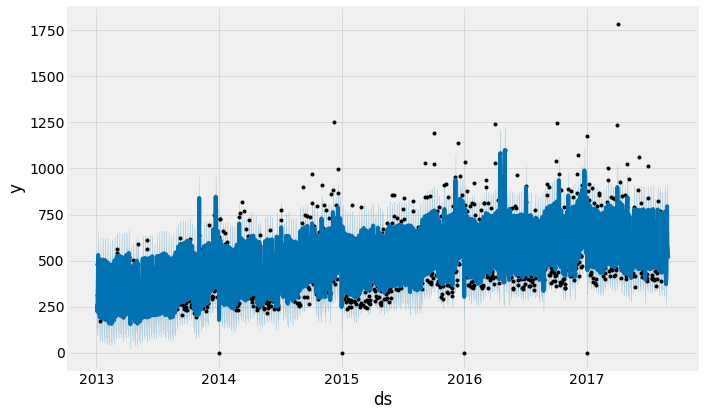

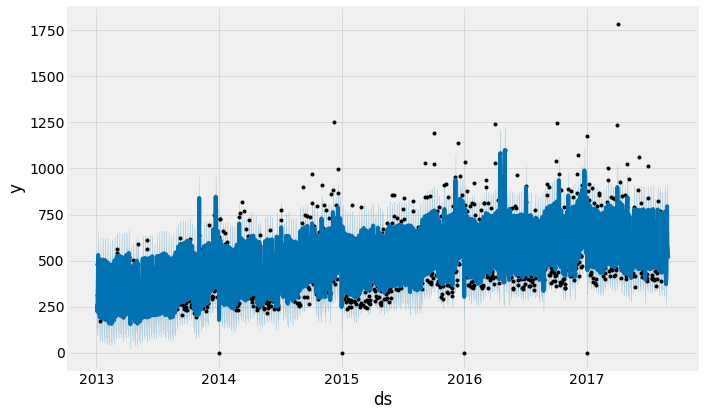

In [43]:
# Plot the forecast 1, the mean sales for each day.
prophet_1.plot(forecast_1)

NOTE: The above does not look great. There are a ton of outlier sales we are missing for some reason. But, we do have peaks where there are big peaks for the most part, so we'll see.

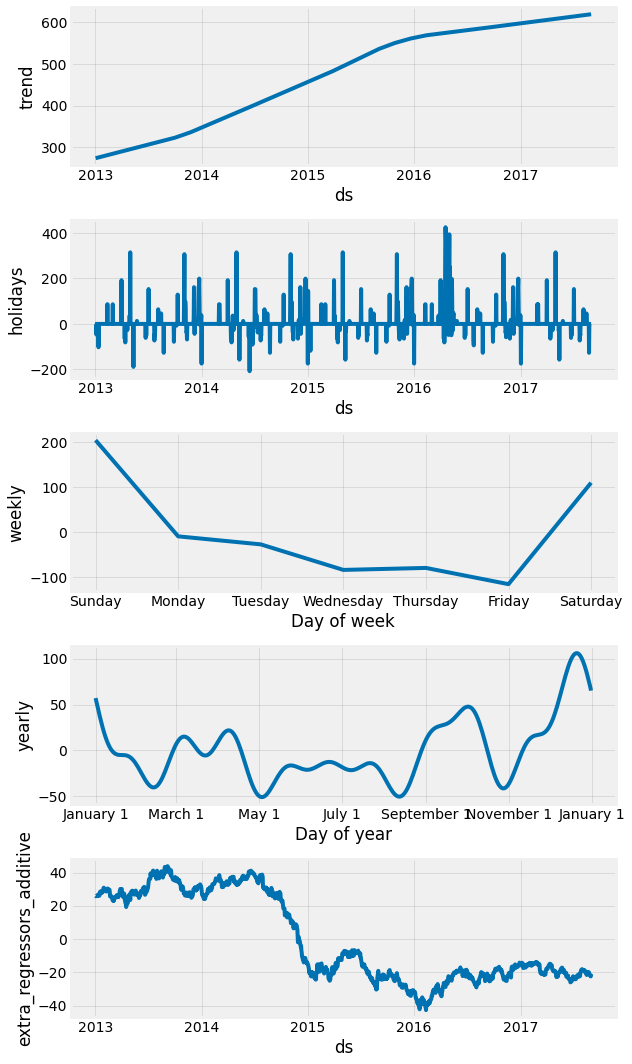

In [44]:
# Use built ins to get the trend, holidays, and seasonal plots over time
plt_components = prophet_1.plot_components(forecast_1)

### Cross-Validation and Hyperparameter Tuning
https://facebook.github.io/prophet/docs/diagnostics.html

In [45]:
df = prophet_df
df.head()

ds           y        oil
0 2013-01-02  480.832848  93.140000
1 2013-01-03  316.112697  92.970000
2 2013-01-04  245.004818  93.120000
3 2013-01-05  395.670000  93.146667
4 2013-01-06  482.925152  93.173333

In [46]:
# Implement Cross validation
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [47]:
# Python
#import itertools
#import numpy as np
#import pandas as pd


#param_grid = {  
#    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#}

## Generate all combinations of parameters
#all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
#rmses = []  # Store the RMSEs for each params here

## Use cross validation to evaluate all parameters
#for params in all_params:
#    m = Prophet(**params).fit(df)  # Fit model with given params
#    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
#    df_p = performance_metrics(df_cv, rolling_window=1)
#    rmses.append(df_p['rmse'].values[0])

## Find the best parameters
#tuning_results = pd.DataFrame(all_params)
#tuning_results['rmse'] = rmses
#print(tuning_results)

In [48]:
#best_params = all_params[np.argmin(rmses)]
#print(best_params)

We see from the cross-validation procedure above that the following hyperparameters yielded the best results:
1. changepoint_prior_scale = 0.01
2. seasonality_prior_scale = 0.1
Other hyperparamers we should probably search going forward include: 
3. holidays_prior_scale
4. seasonality_mode

In [49]:
prophet_cv = Prophet(holidays=holidays_prophet, changepoint_prior_scale=0.01, seasonality_prior_scale=0.1)
prophet_cv.add_regressor('oil')
prophet_cv.fit(prophet_df)

Initial log joint probability = -10.229
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4017.04    0.00225323       644.621           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       4021.04   0.000712029       611.421   1.445e-06       0.001      199  LS failed, Hessian reset 
     183       4021.64   1.13296e-05       407.642   2.787e-08       0.001      297  LS failed, Hessian reset 
     199       4021.65   4.03321e-07       389.249      0.3433           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       4021.65   5.98024e-09       403.251      0.1495      0.1495      343   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [50]:
# Predict 16 days into the future to 8/31/2017, the last day the test data runs through
future_cv = prophet_cv.make_future_dataframe(periods=16, freq='D')
#future['oil'] = future['ds'].apply(oil)
# Merge the future predictions with oil_prophet, which goes through 8/31/2017 as well
future_cv = pd.merge(future, oil_prophet, how='left',on='ds')
forecast_cv = prophet_cv.predict(future)

forecast_cv_out = forecast_cv[['ds','yhat']]
forecast_cv_out.tail()

ds        yhat
1694 2017-08-27  814.710780
1695 2017-08-28  606.027432
1696 2017-08-29  592.546983
1697 2017-08-30  539.868691
1698 2017-08-31  547.961625

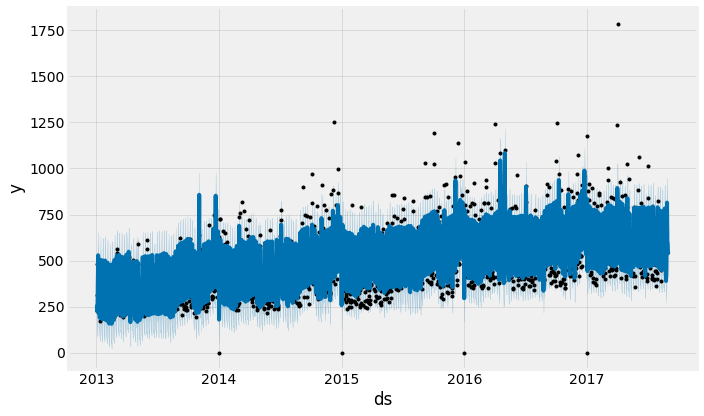

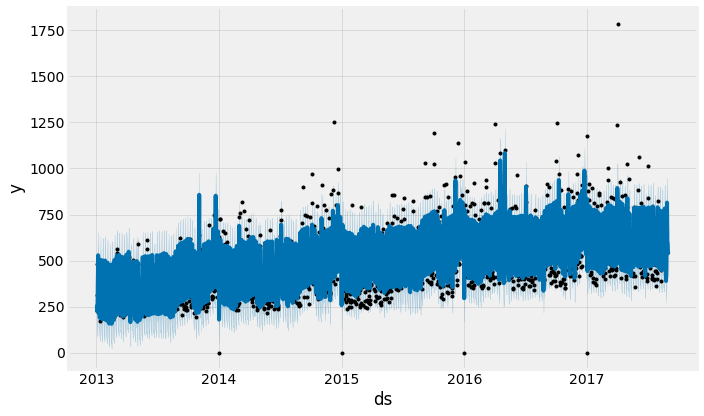

In [51]:
prophet_cv.plot(forecast_cv)

### Working with Test Data

Note that, in test data, there is a unique id associated with each date, each store number and each family of product. We have to make a prediction for all. What we can currently do is predict the average sale of each store per day, which probably will work terribly for products that aren't sold often like Lawn and Garden or Beauty. Grocery and produce and poultry/meat sales dominate as we saw earlier. Here are some options to proceed:
1. Use Family and Store Number Weights: Have prophet predict the mean store sales as we trained it to do. Then go through each day and create a new data frame where we multiply each mean sales and multiply it by the store ratio and the family ratio to get the prediciton for each id we need. 

In [52]:
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv',parse_dates=['date'], infer_datetime_format=True)

In [53]:
test.head()

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

In [54]:
# Let's grab Prophet's predictions for 8-16-2017 through 8-31-2017
forecast_cv_future = forecast_cv_out[forecast_cv_out.ds >= '2017-08-16']
# Now multiply the mean for that day by the ratio for store 1 and for the product AUTOMOTIVE
#forecast_test_future.loc[1683,'yhat']*total_sales_each_store[total_sales_each_store.store_nbr == 1].ratio*ratio_df.loc[1-1, 'AUTOMOTIVE']

In [55]:
# Create short names for df's
store_r = total_sales_each_store
family_r = ratio_df
store_r.head()

store_nbr         sales     ratio
0          1  2.436518e+06  0.012545
1          2  3.564824e+06  0.018355
2          3  8.712340e+06  0.044859
3          4  3.126437e+06  0.016098
4          5  2.287996e+06  0.011781

In [56]:
# First, merge test df with our forecasted values
preds = pd.merge(test, forecast_cv_future, left_on='date', right_on='ds', how='left')
# For each row in this df, multiply yhat by our ratios. Loop over stores first
preds.head()

id       date  store_nbr      family  onpromotion         ds      yhat
0  3000888 2017-08-16          1  AUTOMOTIVE            0 2017-08-16  482.5529
1  3000889 2017-08-16          1   BABY CARE            0 2017-08-16  482.5529
2  3000890 2017-08-16          1      BEAUTY            2 2017-08-16  482.5529
3  3000891 2017-08-16          1   BEVERAGES           20 2017-08-16  482.5529
4  3000892 2017-08-16          1       BOOKS            0 2017-08-16  482.5529

In [57]:
def get_fam_ratios(row, fam_ratios):
    row_store = row.store_nbr
    row_fam = row.family
    row['fam_ratio'] = fam_ratios.loc[row_store - 1, row_fam]
    return row
#get_fam_ratios(preds_store_ratios.loc[0,:], family_r)

In [58]:
# Try merging submit with ratios for each store
preds_store_ratios = pd.merge(preds, store_r, left_on='store_nbr', right_on='store_nbr')
preds_store_ratios.rename(columns={'ratio': 'store_ratio'},inplace=True)
preds_store_ratios['fam_ratio'] = 0
#preds_sf_ratios = pd.merge(preds_store_ratios, family_r, left_on=['store_nbr','family'],right_on=['store_nbr','family'])
preds_store_ratios.head()

id       date  store_nbr      family  onpromotion         ds  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0 2017-08-16   
1  3000889 2017-08-16          1   BABY CARE            0 2017-08-16   
2  3000890 2017-08-16          1      BEAUTY            2 2017-08-16   
3  3000891 2017-08-16          1   BEVERAGES           20 2017-08-16   
4  3000892 2017-08-16          1       BOOKS            0 2017-08-16   

       yhat         sales  store_ratio  fam_ratio  
0  482.5529  2.436518e+06     0.012545          0  
1  482.5529  2.436518e+06     0.012545          0  
2  482.5529  2.436518e+06     0.012545          0  
3  482.5529  2.436518e+06     0.012545          0  
4  482.5529  2.436518e+06     0.012545          0

In [59]:
preds_store_ratios = preds_store_ratios.apply(lambda row: get_fam_ratios(row, family_r), axis=1)

In [60]:
preds_store_ratios.drop(['sales','ds'],axis=1, inplace=True)
preds_store_ratios['sales']= preds_store_ratios.yhat*preds_store_ratios.store_ratio*preds_store_ratios.fam_ratio

In [61]:
submit = preds_store_ratios[['id','sales']]
submit.head()

id      sales
0  3000888   0.092080
1  3000889   0.000000
2  3000890   0.086500
3  3000891  41.064985
4  3000892   0.000000

In [62]:
submit.to_csv('submission.csv', index=False)